In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score
import matplotlib.pyplot as plt
import pandas as pd

# Load the dataset
data = pd.read_csv("11_2_Test.csv")

# Features for clustering
features = ["Distance", "Amplitude", "Tau", "DOA", "RTT"]
X = data[features]

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply KMeans clustering
kmeans = KMeans(n_clusters=6, random_state=42)  # 6 clusters for 6 unique labels
data["Cluster"] = kmeans.fit_predict(X_scaled)

# Adjust true labels to match cluster indexing (0-5 instead of 1-6)
true_labels = data["LOS/NLOS"] - 1

# Evaluate clustering performance
ari_score = adjusted_rand_score(true_labels, data["Cluster"])

# Calculate percentage of correct matches
correct_matches = sum(true_labels == data["Cluster"])
total_samples = len(true_labels)
accuracy_percentage = (correct_matches / total_samples) * 100

print(f"Adjusted Rand Index (ARI) Score: {ari_score}")
print(f"Percentage of correct matches: {accuracy_percentage:.2f}%")

# Visualize clusters using PCA for dimensionality reduction
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
data["PCA1"] = X_pca[:, 0]
data["PCA2"] = X_pca[:, 1]

# Plot the clusters
plt.figure(figsize=(10, 7))
for cluster in range(6):
    cluster_data = data[data["Cluster"] == cluster]
    plt.scatter(cluster_data["PCA1"], cluster_data["PCA2"], label=f'Cluster {cluster}')
    
plt.title('K-Means Clustering with PCA Visualization')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.grid(True)
plt.show()

# Save clustered data to a new file
data.to_csv("clustered_data_with_pca.csv", index=False)
print("Clustered data saved to 'clustered_data_with_pca.csv'.")

In [513]:
from scipy.optimize import linear_sum_assignment
import numpy as np

# Create a confusion matrix
confusion_matrix = pd.crosstab(data["Cluster"], true_labels)

# Use Hungarian Algorithm to find the optimal mapping
row_ind, col_ind = linear_sum_assignment(-confusion_matrix.values)

# Remap the cluster labels
mapping = {row: col for row, col in zip(row_ind, col_ind)}
data["Mapped_Cluster"] = data["Cluster"].map(mapping)

# Recalculate percentage of correct matches
correct_matches = sum(true_labels == data["Mapped_Cluster"])
accuracy_percentage = (correct_matches / total_samples) * 100

print(f"Adjusted Rand Index (ARI) Score: {ari_score}")
print(f"Percentage of correct matches after mapping: {accuracy_percentage:.2f}%")


Adjusted Rand Index (ARI) Score: 0.05924156121689564
Percentage of correct matches after mapping: 35.67%


In [514]:
from sklearn.metrics import accuracy_score

# Mapowanie klastrów na dominujące etykiety w kolumnie Paths
cluster_to_label = data.groupby("Cluster")["LOS/NLOS"].agg(lambda x: x.mode()[0])

# Przypisanie dominujących etykiet do danych na podstawie klastrów
data["Predicted Paths"] = data["Cluster"].map(cluster_to_label)

# Obliczenie procentowej zgodności
accuracy = accuracy_score(data["LOS/NLOS"], data["Predicted Paths"]) * 100
print(f"Procentowa zgodność danych z klastrami: {accuracy:.2f}%")

Procentowa zgodność danych z klastrami: 72.98%


In [515]:
# Mapowanie klastrów na dominujące etykiety w kolumnie Paths
cluster_to_label = data.groupby("Cluster")["LOS/NLOS"].agg(lambda x: x.mode()[0])

# Przypisanie dominujących etykiet do danych na podstawie klastrów
data["Predicted Paths"] = data["Cluster"].map(cluster_to_label)

# Dodanie informacji o poprawności predykcji
data["Correct"] = data["LOS/NLOS"] == data["Predicted Paths"]

# Podsumowanie wyników dla każdej grupy
group_summary = data.groupby("Cluster").agg(
    Total=("LOS/NLOS", "count"),
    Correct=("Correct", "sum"),
    Incorrect=("Correct", lambda x: (~x).sum())
)

# Dodanie procentowej poprawności
group_summary["Accuracy (%)"] = (group_summary["Correct"] / group_summary["Total"]) * 100

# Wyświetlenie szczegółowego podsumowania
# print(group_summary)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical


data = pd.read_csv("11_2_Test.csv")

X = data[["Distance", "Amplitude", "Tau","DOA", "RTT"]]
y = data["LOS/NLOS"]


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Konwersja etykiet na format one-hot
y_categorical = to_categorical(y)

# Podział na dane treningowe i testowe
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_categorical, test_size=0.2, random_state=42)




# Budowa sieci neuronowej
model = Sequential([
    Dense(64, input_dim=X_train.shape[1], activation='selu'),  # Warstwa ukryta
    Dense(32, activation='selu'),                              # Kolejna warstwa ukryta
    Dense(y_train.shape[1], activation='softmax')              # Warstwa wyjściowa
])

# Kompilacja modelu
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Trenowanie modelu
history = model.fit(X_train, y_train, epochs=200, batch_size=32, validation_split=0.2, verbose=1)

# Ocena modelu
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Dokładność na zbiorze testowym: {accuracy * 100:.2f}%")

# Predykcja
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

# Raport klasyfikacji
print(classification_report(y_test_labels, y_pred_labels))

# Macierz konfuzji
cm = confusion_matrix(y_test_labels, y_pred_labels)
ConfusionMatrixDisplay(cm, display_labels=np.unique(data["LOS/NLOS"])).plot(cmap="Blues")
plt.title("Macierz konfuzji")
plt.show()

# Wizualizacja historii uczenia
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Dokładność na treningu')
plt.plot(history.history['val_accuracy'], label='Dokładność na walidacji')
plt.title("Historia dokładności")
plt.xlabel("Epoka")
plt.ylabel("Dokładność")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Strata na treningu', color='blue')
plt.plot(history.history['val_loss'], label='Strata na walidacji', color='orange')
plt.title("Historia funkcji strat")
plt.xlabel("Epoka")
plt.ylabel("Strata")
plt.legend()
plt.grid(True)
plt.show()


import seaborn as sns

# Heatmapa macierzy konfuzji
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(data["LOS/NLOS"]), yticklabels=np.unique(data["LOS/NLOS"]))
plt.title("Heatmapa macierzy konfuzji")
plt.xlabel("Przewidywane klasy")
plt.ylabel("Rzeczywiste klasy")
plt.show()


plt.figure(figsize=(12, 6))
for i in range(y_pred.shape[1]):
    plt.hist(y_pred[:, i], bins=20, alpha=0.5, label=f"Klasa {i}")
plt.title("Rozkład przewidywanych prawdopodobieństw")
plt.xlabel("Prawdopodobieństwo")
plt.ylabel("Liczba próbek")
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(10, 6))
plt.scatter(y_test_labels, y_pred_labels, alpha=0.6, c='blue', label="Próbki")
plt.title("Porównanie przewidywanych i rzeczywistych etykiet")
plt.xlabel("Rzeczywiste etykiety")
plt.ylabel("Przewidywane etykiety")
plt.xticks(np.unique(y_test_labels))
plt.yticks(np.unique(y_test_labels))
plt.grid(True)
plt.legend()
plt.show()



correct_by_class = []
incorrect_by_class = []

for cls in np.unique(y_test_labels):
    correct = sum((y_test_labels == cls) & (y_pred_labels == cls))
    incorrect = sum((y_test_labels == cls) & (y_pred_labels != cls))
    correct_by_class.append(correct)
    incorrect_by_class.append(incorrect)

x = np.arange(len(np.unique(y_test_labels)))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x - width / 2, correct_by_class, width, label='Poprawne', color='green')
plt.bar(x + width / 2, incorrect_by_class, width, label='Niepoprawne', color='red')
plt.xlabel("Klasy")
plt.ylabel("Liczba próbek")
plt.title("Poprawne vs niepoprawne klasyfikacje dla każdej klasy")
plt.xticks(x, labels=np.unique(y_test_labels))
plt.legend()
plt.grid(True)
plt.show()

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 657us/step
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 644us/step
Cechy Distance: Wpływ na dokładność = 0.1599
Cechy Amplitude: Wpływ na dokładność = 0.0851
Cechy Tau: Wpływ na dokładność = 0.2376
Cechy DOA: Wpływ na dokładność = 0.0430
Cechy RTT: Wpływ na dokładność = 0.1586


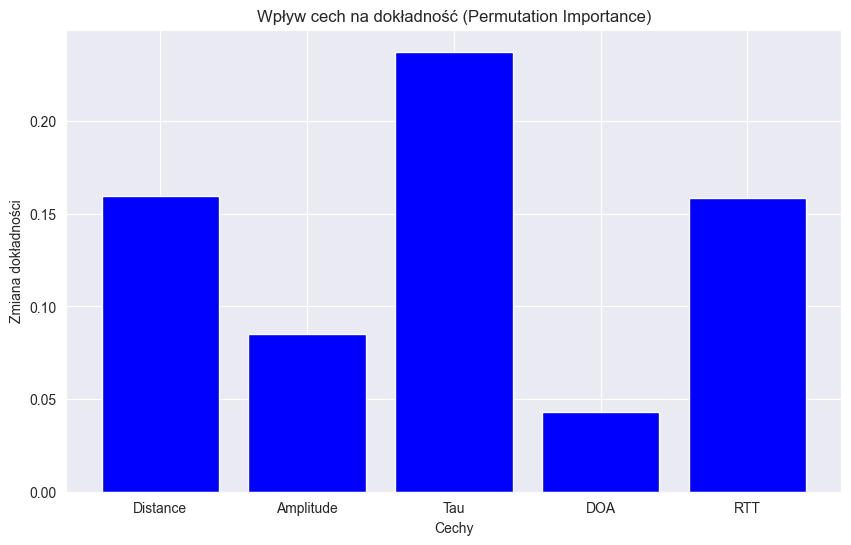

In [518]:
from sklearn.metrics import accuracy_score

# Funkcja do obliczenia wpływu cech metodą permutacji
def permutation_importance(model, X_test, y_test, metric=accuracy_score):
    base_score = metric(np.argmax(model.predict(X_test), axis=1), np.argmax(y_test, axis=1))
    importances = []
    
    for i in range(X_test.shape[1]):
        X_test_permuted = X_test.copy()
        np.random.shuffle(X_test_permuted[:, i])  # Losowa permutacja cechy
        permuted_score = metric(np.argmax(model.predict(X_test_permuted), axis=1), np.argmax(y_test, axis=1))
        importances.append(base_score - permuted_score)
    
    return importances

# Obliczenie wpływu cech
feature_importances = permutation_importance(model, X_test, y_test)

# Wyświetlenie wyników
for i, importance in enumerate(feature_importances):
    print(f"Cechy {X.columns[i]}: Wpływ na dokładność = {importance:.4f}")

# Wizualizacja wpływu cech
plt.figure(figsize=(10, 6))
plt.bar(X.columns, feature_importances, color="blue")
plt.title("Wpływ cech na dokładność (Permutation Importance)")
plt.xlabel("Cechy")
plt.ylabel("Zmiana dokładności")
plt.grid(True)
plt.show()

In [1]:

    """Rysuje wykres dokładności predykcji dla każdej klasy."""
    report = classification_report(y_true, y_pred, output_dict=True)
    class_accuracies = [report[str(label)]['precision'] for label in class_labels]
    
    plt.figure(figsize=(10, 6))
    plt.bar(class_labels, class_accuracies, color='skyblue')
    plt.xlabel("Klasa")
    plt.ylabel("Dokładność predykcji")
    plt.title("Dokładność predykcji dla każdej klasy")
    plt.ylim(0, 1)
    plt.xticks(class_labels)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    for i, acc in enumerate(class_accuracies):
        plt.text(class_labels[i], acc + 0.02, f"{acc:.2f}", ha='center', fontsize=12)
    
    plt.show()
